#### About

- Model Building: Construct a CNN using PyTorch, focusing on architecture, loss function, and optimizer selection.  
- Training and Evaluation: Training the model and followed by evaluation with accuracy, confusion matrix, and ROC curve metrics.  
- Model Saving and Loading: Instructions for saving the trained model and loading a pre-trained model for comparison (evaluation).  

Importing Libraries 

In [1]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
# import pytorch relevant
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
# import tools for evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

TODO: Define the location where you place the dataset you downloaded

In [8]:
# define the location
PATH = "E:/Github Projects/BIOF2001/PBL 8/chest_xray/"

In [9]:
# define some resuable functions to reduce the redundancy of the code
def encode_label(label_str):
    if label_str == "NORMAL":
        return 0
    else:
        return 1
def fetch_data(split, category):
    fnames = os.listdir(PATH + split + '/' + category)
    X_, y_ = [], []
    for fname in fnames:
        if '.jpeg' in fname:
            with Image.open(PATH + split + '/' + category + '/' + fname).convert('L') as img:
                img_resized = img.resize((100,100), Image.LANCZOS)
                img_array = np.asarray(img_resized) / 255.0
                X_.append(img_array)
            label = encode_label(category)
            y_.append(label)
    return np.array(X_).astype('float32'), np.array(y_).astype('float32')

In [10]:
X_train_neg, y_train_neg = fetch_data('train', 'NORMAL')
X_train_pos, y_train_pos = fetch_data('train', 'PNEUMONIA')

X_train = np.concatenate((X_train_neg, X_train_pos))
y_train = np.concatenate((y_train_neg, y_train_pos))

Loading in the train dataset using the function fetch_data()

TODO: Reuse these two functions to get testing set (X_test and y_test)

In [11]:
X_test_neg, y_test_neg = fetch_data('test', 'NORMAL')
X_test_pos, y_test_pos = fetch_data('test', 'PNEUMONIA')

X_test = np.concatenate((X_test_neg, X_test_pos))
y_test= np.concatenate((y_test_neg, y_test_pos))

Loading in the test dataset using the function fetch_data()

In [12]:
# print out the shape of the dataset
print(X_train.shape, " || ", y_train.shape, " || ", X_test.shape, " || ", y_test.shape)

(5216, 100, 100)  ||  (5216,)  ||  (624, 100, 100)  ||  (624,)


The training data consists of 5,216 samples and The testing data consists of 624 samplesThe testing data consists of 624 samples

In [37]:
# Checking for class imbalance in the training set
print("Number of normal images in the training set: ", np.sum(y_train == 0))
print("Number of pneumonia images in the training set: ", np.sum(y_train == 1))
print("Ratio of normal to pneumonia images in the training set: ", np.sum(y_train == 0) / np.sum(y_train == 1))

Number of normal images in the training set:  1341
Number of pneumonia images in the training set:  3875
Ratio of normal to pneumonia images in the training set:  0.3460645161290323


There is a class imbalance in the training dataset.

TODO: Use matplotlib to present one chest X-ray image

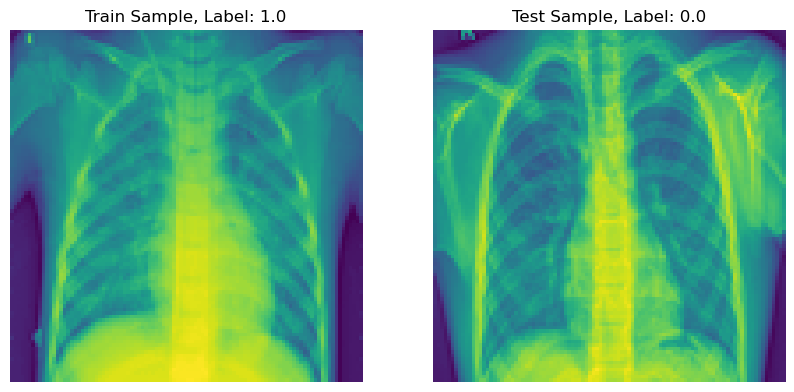

In [17]:
# Select a random sample from each dataset to display
train_sample_index = np.random.randint(0, X_train.shape[0])
test_sample_index = np.random.randint(0, X_test.shape[0])

# Plotting the selected samples
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(X_train[train_sample_index])
plt.title(f"Train Sample, Label: {y_train[train_sample_index]}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(X_test[test_sample_index])
plt.title(f"Test Sample, Label: {y_test[test_sample_index]}")
plt.axis('off')

plt.show()

The code snippet above is a simple visual verification step to ensure the correct loading of datasets, specifically the train and test datasets. The code plots two random sample images, one from each dataset, allowing for a visual inspection of the loaded data.

In [18]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding='same')
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 3, padding='same')
        
        self.fc1 = nn.Linear(16 * 25 * 25, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

In [19]:
net = Net()

TODO: Print out the architecture of the network you defined

In [20]:
print(net)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (fc1): Linear(in_features=10000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


This model CNN model designed for binary classification tasks involving 2D input ( in our case, images). It starts with two convolutional layers that extract features from the input, each followed by a max pooling layer to reduce the data's spatial dimensions and highlight the most important features. The extracted features are then flattened and passed through three fully connected layers, progressively narrowing down to a single output value. This output, after being passed through a sigmoid activation function, represents the probability that the input belongs to a specific class (Binary classification).

In [21]:
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters())

The Binary Cross-Entropy (BCE) Loss function and the Adam optimizer are utilized for a neural network.

The BCE Loss function measures the performance of a model whose output is a probability value between 0 and 1. It's used for binary classification tasks. Alternatives include CrossEntropyLoss for multi-class classification and Mean Squared Error (MSE) Loss for regression tasks.

The Adam optimizer is an optimization algorithm that adjusts the learning rate for each parameter,  its is effectiven in handling sparse gradients and noisy problems (such as images). We could also use SGD (Stochastic Gradient Descent) or RMSprop.

In [22]:
X_tensor = torch.tensor(X_train).unsqueeze(1)
y_tensor = torch.tensor(y_train).unsqueeze(1)

In [23]:
batch_size = 128
dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, shuffle=True, batch_size=batch_size)

In the context of training neural networks, the batch_size hyperparameter plays a critical role in determining the computational efficiency, convergence rate, and overall performance of the learning algorithm. Specifically, batch_size refers to the number of training examples utilized in one iteration of the model's update. In the provided code snippet, batch_size is set to 128, indicating that the model weights are updated after computing the loss on 128 training examples. Smaller batch sizes typically require a lower learning rate to maintain stability in the training process, whereas larger batches can often accommodate higher learning rates.

Reference: https://www.youtube.com/watch?v=K20lVDVjPn4&pp=ygUKQmF0Y2ggc2l6ZQ%3D%3D

In [24]:
for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.5f}')
            running_loss = 0.0

print('Finished Training')

[1,    20] loss: 0.00565
[1,    40] loss: 0.00422
[2,    20] loss: 0.00241
[2,    40] loss: 0.00207
[3,    20] loss: 0.00137
[3,    40] loss: 0.00117
[4,    20] loss: 0.00126
[4,    40] loss: 0.00120
[5,    20] loss: 0.00112
[5,    40] loss: 0.00091
[6,    20] loss: 0.00084
[6,    40] loss: 0.00094
[7,    20] loss: 0.00096
[7,    40] loss: 0.00086
[8,    20] loss: 0.00067
[8,    40] loss: 0.00074
[9,    20] loss: 0.00063
[9,    40] loss: 0.00071
[10,    20] loss: 0.00057
[10,    40] loss: 0.00067
[11,    20] loss: 0.00060
[11,    40] loss: 0.00063
[12,    20] loss: 0.00063
[12,    40] loss: 0.00059
[13,    20] loss: 0.00053
[13,    40] loss: 0.00058
[14,    20] loss: 0.00038
[14,    40] loss: 0.00055
[15,    20] loss: 0.00042
[15,    40] loss: 0.00057
[16,    20] loss: 0.00070
[16,    40] loss: 0.00056
[17,    20] loss: 0.00044
[17,    40] loss: 0.00046
[18,    20] loss: 0.00041
[18,    40] loss: 0.00033
[19,    20] loss: 0.00034
[19,    40] loss: 0.00031
[20,    20] loss: 0.00026
[20,

In [25]:
with torch.no_grad():
    pred_prob = net(torch.from_numpy(X_test).unsqueeze(1)).numpy()

In [26]:
output = np.round(pred_prob)
target = y_test

TODO: Generate classification report, confusion matrix, and draw the ROC curve for your model

In [27]:
# print out the classification report
print(classification_report(target, output))

              precision    recall  f1-score   support

         0.0       0.98      0.27      0.42       234
         1.0       0.69      1.00      0.82       390

    accuracy                           0.72       624
   macro avg       0.84      0.63      0.62       624
weighted avg       0.80      0.72      0.67       624



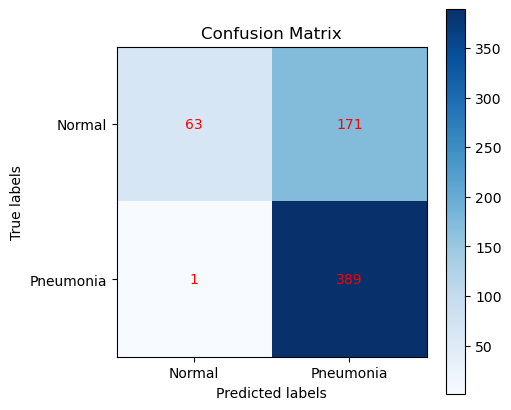

In [33]:
# Plot a confusion matrix with numbers on it
cm = confusion_matrix(target, output)
plt.figure(figsize=(5, 5))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks([0, 1], ['Normal', 'Pneumonia'])
plt.yticks([0, 1], ['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

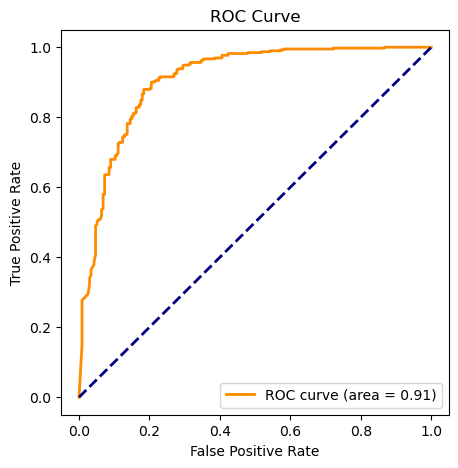

In [35]:
# Generating the ROC curve with AUC score label
fpr, tpr, _ = roc_curve(target, pred_prob)
auc = roc_auc_score(target, pred_prob)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

The ROC curve yields an AUC of 0.91, indicating a high overall ability to distinguish between the pneumonia and normal classes. However, a closer look at the precision, recall, and F1-scores reveals a disparity in performance between the classes.

For the normal class, the model shows a high precision (0.98) but a very low recall (0.27), resulting in a poor F1-score (0.42). And, for the pneumonia class, the model achieves perfect recall (1.00) but lower precision (0.69), with a much better F1-score (0.82). The overall accuracy of the model stands at 72%.

The confusion matrix shows a large number of false positives for normal cases (171 out of 234), which is concerning for clinical application. While the model is effective at identifying pneumonia with few false negatives (1 out of 391), the high false-positive rate for normal cases could lead to over-treatment.

The model does not appear to overfit given the reasonable AUC. However, the significantly low recall for normal X-rays could indicate underfitting to that class, perhaps due to the class imbalance or inadequate feature extraction for normal cases.

In a healthcare setting, such imprecision could have serious consequences, suggesting the model is currently not suitable for clinical use without further improvement. 

We can improve the model by addressing the class imbalance, with techniques like oversampling the minority class or undersampling the majority class. We can also Perform more extensive hyperparameter tuning (Smaller batch size, etc) and try different models and/or architectures. We may also increase the size of the dataset or augment the data to provide more examples for the model to learn from, especially for the normal class. We can change the Loss function to Focal Loss, which  gives a penalty for misclassifying the minority class.

In [38]:
torch.save(net, "trained_model_local.pt")

TODO: Load the pretrained model and do the evaluation again

In [40]:
loaded_net = torch.load("pre_trained_model.pt")

In [41]:
# Evaluate the loaded (pre-trained) model
with torch.no_grad():
    pred_prob = loaded_net(torch.from_numpy(X_test).unsqueeze(1)).numpy()

output = np.round(pred_prob)
target = y_test

In [42]:
# print out the classification report
print(classification_report(target, output))

              precision    recall  f1-score   support

         0.0       0.95      0.44      0.60       234
         1.0       0.74      0.99      0.85       390

    accuracy                           0.78       624
   macro avg       0.85      0.71      0.72       624
weighted avg       0.82      0.78      0.75       624



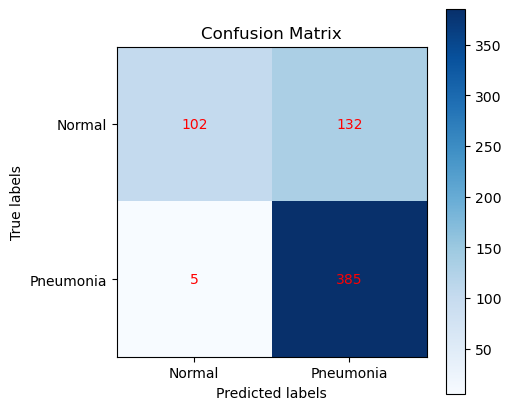

In [45]:
# Plot a confusion matrix with numbers on it
cm = confusion_matrix(target, output)
plt.figure(figsize=(5, 5))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks([0, 1], ['Normal', 'Pneumonia'])
plt.yticks([0, 1], ['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

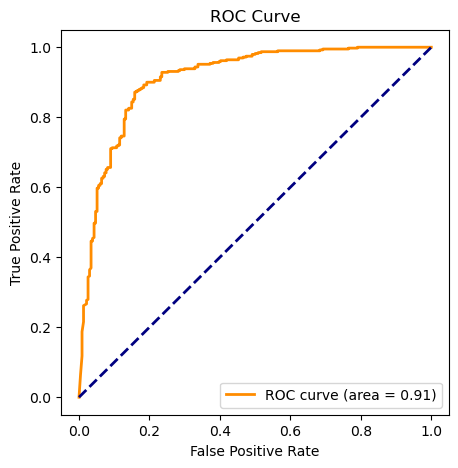

In [44]:
# Generating the ROC curve with AUC score label
fpr, tpr, _ = roc_curve(target, pred_prob)
auc = roc_auc_score(target, pred_prob)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

The pretrained model's performance on the test dataset shows some improvements. Precision remains high for normal cases and has increased for pneumonia cases, indicating more reliable predictions. Notably, the recall for normal X-rays has improved significantly, suggesting a reduced risk of missed diagnoses. Overall accuracy has risen to 78%, and the F1-score improvements for both classes demonstrate a stronger balance between precision and recall. The reduction in false positives for normal cases and a slight increase in false negatives for pneumonia suggest the model is becoming more nuanced in its classification capabilities. These enhancements suggest the pretrained model could offer slightly more dependable support in a clinical setting.

#### Reflection & Summary

- Need to learn more about other Loss functions
- Need to learn about various data augmentation techniques
- Need to learn about all the other parameters. 